# Lorentz Booster
- Generate a whole bunch of particles moving at some relative velocity, then lorentz boost into their frame. This is done compactly by
$$
\bar{\eta}^\mu = \Lambda^\mu_\nu \eta^\nu
$$
where $\eta$ is the 

In [ ]:
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.stats import gaussian_kde
import scipy.stats as stats
%matplotlib inline

# my own little library for dealing with four vectors
import fourvectors as fv

In [2]:
### Constants
c = 3E8
EPSILON_0 = 8.85E-12

### Create enums of particle properties, could be useful for multi-species experiments
class Proton(Enum):
    NAME   = "PROTON"
    MASS   = 1.672E-27 #kg
    CHARGE = 1.602E-19 #C

class Electron(Enum):
    NAME   = "ELECTRON"
    MASS   = 9.109E-21 #kg
    CHARGE =-1.602E-19 #C

class Reference(Enum):
    """A particle that is simply here to be a reference point."""
    NAME   = "REFERENCE PARTICLE"
    MASS   = 0        #kg
    CHARGE = 0        #C

In [3]:

### Create the particle class, this holds all of the nice info about each particle
class Particle():
    def __init__(
            self,
            species,
            pos0_3v = None,  # a three-position
            pos0_4v = None,  # a four-position
            v0_3v  = None,   # a three-velocity
            v0_4v  = None,   # a four-velocity
            frame  = "LAB"   # defaults to lab frame
        ):

        ### HANDLE INITIAL VELOCITIES

        # if no initial three-velocity specified, assume 0
        if v0_3v is None or v0_4v is None:
            v0_4v = np.array([0, 0, 0, 0])

        # if there is a 3v provided, convert it
        if v0_3v is not None:
            # otherwise set the four velocity to match it
            v0_4v = fv.to_four_velocity(v0_3v)

        ### HANDLE INITIAL POSITIONS

        # if no position specified, assume origin
        if pos0_3v is None or pos0_4v is None:
            pos0_4v = np.array([0, 0, 0, 0])

        # if there is a pos 3v provided, convert it
        if pos0_3v is not None:
            pos0_4v = fv.to_four_position(pos0_3v, 0)

        # Get the parameters from the species of particle
        self.name = species.NAME.value
        self.mass = species.MASS.value
        self.charge = species.CHARGE.value

        self.vel_4v = v0_4v    # four velocity
        self.pos_4v = pos0_4v  # four position
        self.frame  = frame
        
        self.force  = np.array([0, 0, 0])

    ### Lorentz Boost Functionality
    def lorentz_boost_to(self, other):
        """Lorentz boost to another particle's frame"""
        # if the frame is lab, then we're boosting to another particle
        if self.frame == "LAB":
            self.frame = other.name
        else:
            self.frame = other.frame

        # first lorentz boost the velocity
        self.lorentz_boost_from_4v(other.vel_4v)

        # then shift it
        if self.name == "REFERENCE PARTICLE":
            # here, the particle is the reference, and becomes the new reference frame
            self.pos_4v = self.get_separation(other)
        else:
            # otherwise lorentz the separation vector given the velocity of the other
            # (likely the reference)
            self.pos_4v = np.linalg.matmul(
                    fv.lorentz_matrix_x_4v(other.vel_4v), self.get_separation(other)
                )

    def boost_as_reference(self):
        self.lorentz_boost_to(self)

    def lorentz_boost_from_4v(self, to_vel_4v):
        """Lorentz boost given a four-velocity"""
        lorentz_matrix = fv.lorentz_matrix_x_4v(to_vel_4v)
        self.vel_4v = np.linalg.matmul(lorentz_matrix, self.vel_4v)

    def lorentz_boost_from_3v(self, to_vel_3v):
        """Lorentz boost given a three-velocity"""
        self.lorentz_boost_from_4v(fv.to_four_velocity(to_vel_3v))

    def get_separation(self, other):
        """"get the separation vector between the two positions"""
        return self.pos_4v - other.pos_4v

    ### Getters
    def get_3v(self):
        return fv.to_three_velocity(self.vel_4v)

    def get_3p(self):
        return fv.to_three_position(self.pos_4v)

In [4]:
np.set_printoptions(formatter={'float': '{:.5e}'.format})

reference = Particle(Reference, v0_3v = np.array([2.9999E8, 0, 0]), pos0_3v=np.array([0,0,0]))
other_particle = Particle(Electron, v0_3v = np.array([2E8, 0, 0]), pos0_3v=np.array([1,50,0]))

print(f"--- {reference.frame} FRAME ---")
print(f"{reference.name} Velocity: {reference.get_3v()}")
print(f"{reference.name} Position: {reference.get_3p()[0]}")
print(f"{other_particle.name} Velocity: {other_particle.get_3v()}")
print(f"{other_particle.name} Position: {other_particle.get_3p()[0]}")

# perform the lorentz boost
other_particle.lorentz_boost_to(reference)
reference.boost_as_reference()

print(f"\n\n--- {reference.frame} FRAME ---")
print(f"{reference.name} Velocity: {reference.get_3v()}")
print(f"{reference.name} Position: {reference.get_3p()[0]}")
print(f"{other_particle.name} Velocity: {other_particle.get_3v()}")
print(f"{other_particle.name} Position: {other_particle.get_3p()[0]}")

--- LAB FRAME ---
REFERENCE PARTICLE Velocity: [[2.99990e+08 0.00000e+00 0.00000e+00]]
REFERENCE PARTICLE Position: [0.00000e+00 0.00000e+00 0.00000e+00]
ELECTRON Velocity: [[2.00000e+08 0.00000e+00 0.00000e+00]]
ELECTRON Position: [1.00000e+00 5.00000e+01 0.00000e+00]


--- REFERENCE PARTICLE FRAME ---
REFERENCE PARTICLE Velocity: [[0.00000e+00 0.00000e+00 0.00000e+00]]
REFERENCE PARTICLE Position: [0.00000e+00 0.00000e+00 0.00000e+00]
ELECTRON Velocity: [[-2.99950e+08 0.00000e+00 0.00000e+00]]
ELECTRON Position: [1.22476e+02 5.00000e+01 0.00000e+00]


# Bunch of particles exercise (1-D)
I'll assume 10000 particles moving at a normally distributed velocity, just in the $\hat{x}$ direction to start. They will also only live on the $x$-axis.

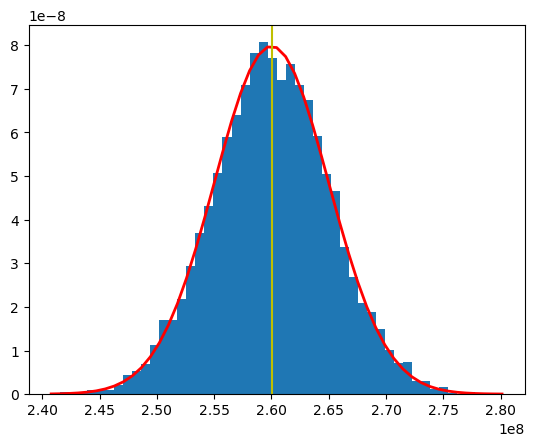

In [5]:
# generate a sample of NUM_PARTICLES particles
NUM_PARTICLES = 10000
MU_VEL, SIGMA_VEL = 2.6E8, 5E6
MU_POS, SIGMA_POS = 0, 10

# create an array of NUM_PARTICLES Particle Objects with random velocities
particle_array = []

for i in range(NUM_PARTICLES):
    # i'm just going to do a whole bunch just going in the x direction
    # and give them a whole lot of positions
    particle_array.append(Particle(
        Electron,
        # could be risky, as the velocity can raise a ValueError
        # if it decides to go above c. its possible, but just
        # really improbable
        v0_3v=[np.random.normal(MU_VEL, SIGMA_VEL), 0, 0],
        pos0_3v=[np.random.normal(MU_POS, SIGMA_POS), 0 ,0]
        ))

def plotNormalWithLine(s, title=None):
    _, bins, _ = plt.hist(s, 50, density=True, label = title)
    plt.plot(bins, 1/(SIGMA_VEL * np.sqrt(2 * np.pi)) *
                np.exp( - (bins - MU_VEL)**2 / (2 * SIGMA_VEL**2) ),
            linewidth=2, color='r')

def getBins1D(s, nbins=50):
    return np.histogram(s, bins=nbins, density=True) # histo, bin_edges

# get the velocities and positions of each particle
particle_vel = np.array([particle.get_3v() for particle in particle_array])
particle_pos = np.array([particle.get_3p()[0] for particle in particle_array])

# get the velocity and position of the reference particle
ref_vel = np.mean(particle_vel, axis=0)[0]
ref_pos = np.mean(particle_pos, axis=0)

# create reference particle
reference = Particle(Reference, v0_3v = ref_vel, pos0_3v = ref_pos)

# create a plot of the velocities, and the reference particle velocity marked with a yellow
plotNormalWithLine(norm(particle_vel, axis=2))
plt.axvline(x = norm(ref_vel), color = 'y', label = 'tiing')

Text(0.5, 1.0, 'Particle Positions (Before Lorentz Boost)')

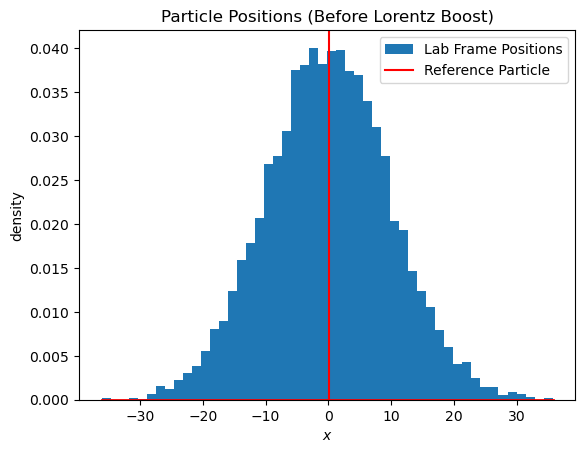

In [6]:
# but the more interesting plot is likely the positions
# i'll just start with printing the x plot

plt.xlabel("$x$")
plt.ylabel("density")
plotNormalWithLine(particle_pos[:,0], title="Lab Frame Positions")
plt.axvline(x = ref_pos[0], color='r', label = 'Reference Particle')
plt.legend()
plt.title("Particle Positions (Before Lorentz Boost)")

In [7]:
# Perform the lorentz boost for each particle
for particle in particle_array:
    particle.lorentz_boost_to(reference)

reference.boost_as_reference()
# get the velocities and positions of each particle
particle_vel_boost = np.array([particle.get_3v() for particle in particle_array])
particle_pos_boost = np.array([particle.get_3p()[0] for particle in particle_array])

# get the velocity and position of the reference particle
ref_vel_boost = np.mean(particle_vel_boost, axis=0)[0]
ref_pos_boost = np.mean(particle_pos_boost, axis=0)

print(ref_vel_boost, ref_pos_boost)

[1.21160e+06 0.00000e+00 0.00000e+00] [-2.88125e-16 0.00000e+00 0.00000e+00]


Text(0.5, 1.0, 'Particle Position Comparison')

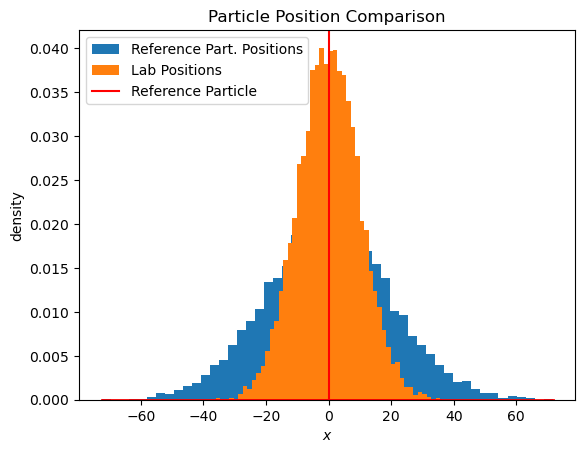

In [8]:
plt.xlabel("$x$")
plt.ylabel("density")
plotNormalWithLine(particle_pos_boost[:,0], title="Reference Part. Positions")
plotNormalWithLine(particle_pos[:,0], title="Lab Positions")
plt.axvline(x = ref_pos[0], color='r', label = 'Reference Particle')
plt.legend()
plt.title("Particle Position Comparison")

## Multi-Gaussian Fitting Exercise
The goal is to take a histogram and fit it with a whole bunch of gaussians, with some parameter that affects smoothness. More Gaussians -> More Spikyness, Less Gaussians -> Less Spikyness


In [9]:
# get the histograms for the positions
lab_density, lab_bins = getBins1D(particle_pos[:,0])
ref_density, ref_bins = getBins1D(particle_pos_boost[:,0])

### Gaussian Function
$$
g(x) = \frac{\exp\left(-\frac{1}{2} \frac{(x - \mu)^2}{\sigma^2}\right)}{\sigma \sqrt{2\pi}}
$$
this is the lambda below

In [10]:
gaussian = lambda x, sig, mu: np.exp(-(x - mu)**2/(2 * sig**2))

class MultiGaussFit():
    def __init__(
                    self,
                    arr,
                    nbins:int = 50,
                    ngaussians:int = 1,
                    width:float = 10.0,
                    mesh = None
                ):

        # get the histogram and bins arrays from the input array
        histo, bins = np.histogram(arr, bins=nbins, density=True)

        # bins = (bins[1:] + bins[:-1])/2

        # if no mesh specified, then overwrite it with a guess
        if mesh is None:
            self.mesh = np.linspace(bins[0], bins[-1], 100000)
            print(f"[INFO] NO MESH SPECIFIED. ASSUMING: N=100000, RANGE=({bins[0]}, {bins[-1]})")
        # if there IS a mesh, then sanitize it
        else:
            self._mesh_isclean()
            # if the mesh is clean, then we good
            self.mesh = mesh


        # set up the array that contains where the gaussians will be centered
        eval_pts = np.zeros((ngaussians, 2))

        # first seed where the gaussians should probably be
        guesses = np.linspace(bins[1], bins[-2], ngaussians)

        # create a place to hold that gaussian fit
        fitted_line = 0
        normsum = 0
        for i in range(ngaussians):
            # get the index of the values closest
            lower_index = int((guesses[i] - bins[0])/(bins[1] - bins[0]))

            # then place the gaussian's peak location at
            eval_pts[i] = ((bins[lower_index]+bins[lower_index+1])/2, histo[lower_index]) # (loc, amplitude)

            # create the gaussians
            fitted_line += eval_pts[i][1] * gaussian(self.mesh, sig=width, mu=eval_pts[i][0])
            normsum += eval_pts[i][1] * (width * np.sqrt(2 * np.pi))

        fitted_line /= normsum

        self.histo = histo
        self.bins = bins
        self.fitted_line = fitted_line

    def _mesh_isclean(self):
        """Ensures the mesh provided is uniformly spaced and monotonically increasing."""
        #uniform spacing check
        dx = np.diff(self.mesh)
        if not (np.allclose(dx, dx[0]) and np.all(dx > 0)):
            raise ValueError("Mesh is not clean!!!")

    def __call__(self, val, pltpoint = None):
        # get the closest point on the mesh
        # get the index of the values closest

        # clamp the value to be in the mesh range
        val = np.clip(val, self.mesh[0], self.mesh[-1])

        lower_index = int((val - self.mesh[0])/(self.mesh[1] - self.mesh[0]))

        # if the user wants to plot where they're getting the value
        if pltpoint is not None:
            plt.plot(self.mesh[lower_index], self.fitted_line[lower_index], "kx")

        return self.fitted_line[lower_index]

    def scale_by_factor(self, num):
        self.fitted_line = num * self.fitted_line
        self.histo = num * self.histo

    def plot_fit(self):
        # plot the where the peaks of the gaussians should be
        plt.stairs(self.histo, self.bins)
        # plt.plot(eval_pts[:,0], eval_pts[:,1], 'kx',  markersize=12)
        plt.plot(self.mesh, self.fitted_line, 'r-')

fit = MultiGaussFit(particle_pos[:,0], nbins=50, ngaussians=50, width=2)

[INFO] NO MESH SPECIFIED. ASSUMING: N=100000, RANGE=(-36.1045209342597, 35.75326701663037)


Create particle distribution, then bin those to get rho, then use jefimenko to get the E at those points
they can be inside a cylinder or sphere.

1. use gauss law to get a plot of |E| (gauss's law for (long) cylinder)
2. then do sphere inside of a cylinder
3. particle distribution inside of cylinder
4. particle distribution moving inside of cylinder

# Gaussian Quadrature
I am implementing
$$
\int_a^b f(x)\,dx = \int_{-1}^1 f \left(\frac{(b-a)t + (b+a)}{2}\right) \frac{(b-a)}{2} \, dt
$$

In [11]:
from numpy.polynomial.legendre import leggauss

def linTransform(t, a, b):
    """Linear transform from [-1,1] to [a,b]"""
    return 0.5 * ((b - a) * t + (a + b))

def gaussQuad3DVec(fxn, x_bounds, y_bounds, z_bounds, n):
    roots, weights = leggauss(n)
    ax, bx = x_bounds
    ay, by = y_bounds
    az, bz = z_bounds

    result = np.zeros(3)

    for i in range(n):
        # get the root from -1->1 to ax->bx
        x = linTransform(roots[i], ax, bx)
        wx = weights[i]
        for j in range(n):
            y = linTransform(roots[j], ay, by)
            wy = weights[j]
            for k in range(n):
                z = linTransform(roots[k], az, bz)
                wz = weights[k]

                fx, fy, fz = fxn(x, y, z)
                w = wx * wy * wz
                result += w * np.array([fx, fy, fz])

    scale = 0.125 * (bx - ax) * (by - ay) * (bz - az)
    return scale * result

def gaussQuad3DCylVec(fxn, s_bounds, z_bounds, phi_bounds, n):
    # multiply our function by the volume element (jacobian)
    cyl_fxn = lambda r, z, phi: fxn(r, z, phi) * np.array([r, 0, 0])
    return gaussQuad3DVec(cyl_fxn, s_bounds, z_bounds, phi_bounds, n)


## Jefimenko's Equation Quadrature
I am solving the first term of Jefimenko's Equation,
$$
E_{rad} = \frac{1}{4\pi\epsilon_0} \int \frac{\rho(\textbf{r}', t_r)(\textbf{r}-\textbf{r}')}{|\textbf{r}-\textbf{r}'|^3} d\tau
$$
Assuming a uniform cylinder of charge density $\rho$, with the origin in the center and the field point directly above the cylinder.

In [12]:
def efldCylinder(R: float, rad_cyl: float, len_cyl: float, quad_points: int = 3, rho=None):
    """Compute radial E-field from a finite charged cylinder using Jefimenko's first term.
    Field is evaluated at a point R away from the cylinder's axis."""

    if rho is None:
        rho = lambda s, z, phi: 1  # Uniform density

    def integrand(s, z, phi):
        # convert the source and field point to be in cartesian
        field_pt = np.array([R, 0, 0])
        source_pt = np.array([s * np.cos(phi), s * np.sin(phi), z])
        separation = field_pt - source_pt
        return rho(s, z, phi) * separation / norm(separation)**3

    return gaussQuad3DCylVec(
        fxn=integrand,
        s_bounds=(0, rad_cyl),
        z_bounds=(-len_cyl / 2, len_cyl / 2),
        phi_bounds=(0, 2 * np.pi),
        n=quad_points
    ) / (4 * np.pi * EPSILON_0)

In [ ]:
### PARAMETERS ###
rad_cyl = 1   # radius of cylinder
len_cyl = 16  # length of cylinder
q_pts = 32    # number of quadrature points
mesh = np.linspace(0.1, 10, 70)

# Case 1: Uniform charged cylinder
rho_scaled = lambda s, z, phi: 1/ (2 * np.pi * rad_cyl**2 ** len_cyl)
efld_vals_const = [efldCylinder(R=r, rad_cyl=rad_cyl, len_cyl=len_cyl, quad_points=q_pts, rho=rho_scaled) for r in mesh]
efld_mags_const = [norm(E) for E in efld_vals_const]

# Case 2: Spherical cutoff charge thing
rho_sphere = lambda s, z, phi: 1 / (4/3 * np.pi * rad_cyl**3) if (np.sqrt(s**2 + z**2) < rad_cyl) else 0
efld_vals_sphere = [efldCylinder(R=r, rad_cyl=rad_cyl, len_cyl=len_cyl, rho=rho_sphere, quad_points=q_pts) for r in mesh]
efld_mags_sphere = [norm(E) for E in efld_vals_sphere]

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/spoink/miniconda3/lib/python3.12/site-packages/flameprof.py", line 404, in <module>
    render(s.stats, get_out(args.out), args.format, args.threshold / 100,
  File "/home/spoink/miniconda3/lib/python3.12/site-packages/flameprof.py", line 305, in render
    blocks, bblocks, maxw = prepare(funcs, calls, threshold=threshold)
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/spoink/miniconda3/lib/python3.12/site-packages/flameprof.py", line 232, in prepare
    _calc_back((f for f in funcs if f != 'root'), 0, None, 0, set(), 0)
  File "/home/spoink/miniconda3/lib/python3.12/site-packages/flameprof.py", line 225, in _calc_back
    _calc_back(func['called'], level+1, name, origin, visited | {key}, ttt)
  File "/home/spoink/miniconda3/lib/python3.12/site-packages/flameprof.py", line 225, in _calc_back
    _

CalledProcessError: Command '['flameprof', '/tmp/tmp5s2xye53/temp_prof.prof']' returned non-zero exit status 1.

         73569992 function calls (68984999 primitive calls) in 71.013 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  4587520   22.143    0.000   45.769    0.000 4145302893.py:8(integrand)
    139/0   13.482    0.097    0.000          520487726.py:7(gaussQuad3DVec)
 18351060    9.947    0.000    9.947    0.000 {built-in method numpy.array}
  4587660    8.124    0.000   15.005    0.000 _linalg.py:2566(norm)
4587519/2968    5.035    0.000    0.036    0.000 520487726.py:35(<lambda>)
  4587660    3.596    0.000    3.596    0.000 {method 'dot' of 'numpy.ndarray' objects}
  2293760    2.622    0.000    2.622    0.000 <string>:13(<lambda>)
  4735360    1.445    0.000    1.445    0.000 520487726.py:3(linTransform)
  4587660    1.171    0.000    1.171    0.000 {method 'ravel' of 'numpy.ndarray' objects}
  9176022    0.860    0.000    0.860    0.000 {built-in method builtins.issubclass}
  2293760    0.809    0.000    0.809    0.000

## Analytical Solutions
### Sphere
$$
\boxed{\textbf{E}_\text{in} = \frac{\rho r}{3\epsilon_0}} \qquad \boxed{\textbf{E}_\text{out} = \frac{\rho R^3}{3\epsilon_0r^2}}
$$
where $r$ is the observation distance, $R$ is the radius of the sphere, and $\rho$ is the charge density.
### Cylinder
$$
\boxed{\textbf{E}_\text{in} = \frac{\rho r}{2 \epsilon_0}} \qquad \boxed{\textbf{E}_\text{out} = \frac{\rho R^2}{2\epsilon_0r}}
$$

In [ ]:
# analytical fields of the sphere and cylinder
efld_sphere = lambda r, rho: r * rho / (3 * EPSILON_0) if r < rad_cyl else rho * rad_cyl**3 / (3 * EPSILON_0 * r**2)
analytical_efld_sphere = [efld_sphere(r, 1/(4/3 * np.pi * rad_cyl**3)) for r in mesh]

efld_cylinder = lambda r, rho: r * rho / (2 * EPSILON_0) if r < rad_cyl else rho * rad_cyl**2 / (2 * EPSILON_0 * r)
analytical_efld_cylinder = [efld_cylinder(r, rho_scaled(0,0,0)) for r in mesh]

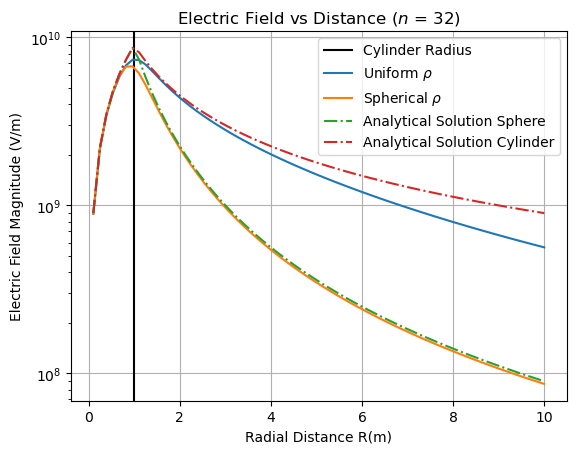

In [ ]:
# Plotting
plt.grid(True)
plt.axvline(x=rad_cyl, label="Cylinder Radius", color="k", linestyle='-')
plt.semilogy(mesh, efld_mags_const, label="Uniform $ρ$")
plt.semilogy(mesh, efld_mags_sphere, label="Spherical $ρ$")
plt.semilogy(mesh, np.array(analytical_efld_sphere), '-.',label = "Analytical Solution Sphere")
plt.semilogy(mesh, np.array(analytical_efld_cylinder), '-.',label = "Analytical Solution Cylinder")
plt.xlabel("Radial Distance R(m)")
plt.ylabel("Electric Field Magnitude (V/m)")
plt.legend()
plt.title(f"Electric Field vs Distance ($n$ = {q_pts})")
plt.show()

# Lorentz Boost Version of this Exercise
I think all that I need to change is the $\rho$ to be determined by the Gaussian curve that I fit. Then, everything else should hopefully fall neatly into place.

In [27]:
###
# STEP 1. Initialize the particles
###
NUM_PARTICLES = 10000
MU_VEL, SIGMA_VEL = 2.6E8, 5E6 # average vel, 1sig of vel
MU_POS, SIGMA_POS = 0, 1E-4      # average pos, 1sig of pos

# create an array of NUM_PARTICLES Particle Objects with random velocities
particle_array = []

for i in range(NUM_PARTICLES):
    # i'm just going to do a whole bunch just going in the x direction
    # and give them a whole lot of positions
    particle_array.append(Particle(
        Electron,
        # generate a velocity that is clamped
        v0_3v=[np.clip(np.random.normal(MU_VEL, SIGMA_VEL),0,c), 0, 0],
        pos0_3v=[np.random.normal(MU_POS, SIGMA_POS), 0 ,0]
        ))

# get the velocities and positions of each particle
particle_vel = np.array([particle.get_3v() for particle in particle_array])
particle_pos = np.array([particle.get_3p()[0] for particle in particle_array])

# get the velocity and position of the reference particle
ref_vel = np.mean(particle_vel, axis=0)[0]
ref_pos = np.mean(particle_pos, axis=0)

# create reference particle
reference = Particle(Reference, v0_3v = ref_vel, pos0_3v = ref_pos)

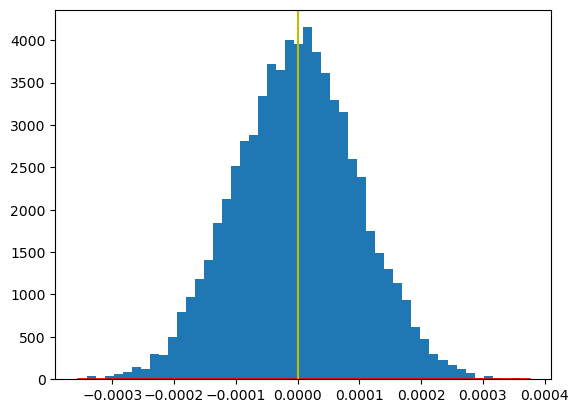

In [28]:
###
# STEP 2: Lorentz boost to the reference particle's frame
###

# Perform the lorentz boost for each particle
for particle in particle_array:
    particle.lorentz_boost_to(reference)

reference.boost_as_reference()

# get the velocities and positions of each particle
lb_particle_vel = np.array([particle.get_3v() for particle in particle_array])
lb_particle_pos = np.array([particle.get_3p()[0] for particle in particle_array])

# get the velocity and position of the reference particle
lb_ref_vel = np.mean(lb_particle_vel, axis=0)[0]
lb_ref_pos = np.mean(lb_particle_pos, axis=0)

# create a plot of the velocities, and the reference particle velocity marked with a yellow
plotNormalWithLine(particle_pos[:,0])
plt.axvline(x = norm(ref_pos), color = 'y', label = 'ref particle pos')

[INFO] NO MESH SPECIFIED. ASSUMING: N=100000, RANGE=(-0.0007109263731080325, 0.0007521387388422741)


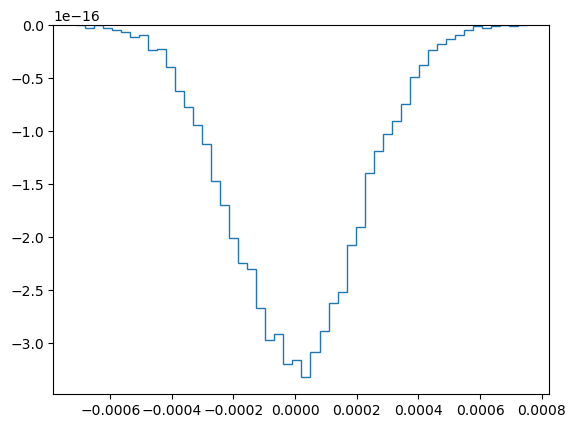

In [29]:
###
# STEP 3: Bin the distribution of particles in the Lorentz-boosted frame
###

lb_mgf = MultiGaussFit(lb_particle_pos[:,0], nbins=50, ngaussians=50, width=3.7)

# now, I can get the number density of the particles at a certain position
# i'll translate this into a charge density

## TODO: Make this return another fit instance instead of scaling the one provided
def numberToChargeDensity(number_density: MultiGaussFit, species):
    # scale by the species charge
    number_density.scale_by_factor(species.CHARGE.value)

# scale the number density to be a charge density by multiplying it all by the electron charge
numberToChargeDensity(lb_mgf, Electron)
lb_mgf.plot_fit()

In [35]:
###
# STEP 3.5: Visualize the electric field strength for radii outside of the bunch
#
# Take the bunch of particles to be a cylinder, and slice it up. Each slice will have a
# charge density determined by the bunched up particles. This is mainly an academic
# exercise right now, but could be interesting in the longer run.
###

### PARAMETERS ###
rad_cyl = 0.001 # radius of bunch (aka cylinder), is somewhat thin

# length of the cylinder, spans the whole mesh.
len_cyl = lb_mgf.bins[-1] - lb_mgf.bins[0]

# number of quadrature points
q_pts = 32

# the various points i want to evaluate the radius at
r_mesh = np.linspace(0.001, 0.01, 70)

# I'm going to take this charge density to be a really thin cylinder that changes along z
# it will be axisymmetric
rho_binned = lambda s, z, phi: lb_mgf(z) if s < rad_cyl else 0

### EVALUATE
lb_efld_vals_binned1D = [efldCylinder(R=r, rad_cyl=rad_cyl, len_cyl=len_cyl, quad_points=q_pts, rho=rho_binned) for r in mesh]
lb_efld_mags_binned1D = [norm(E) for E in lb_efld_vals_binned1D]

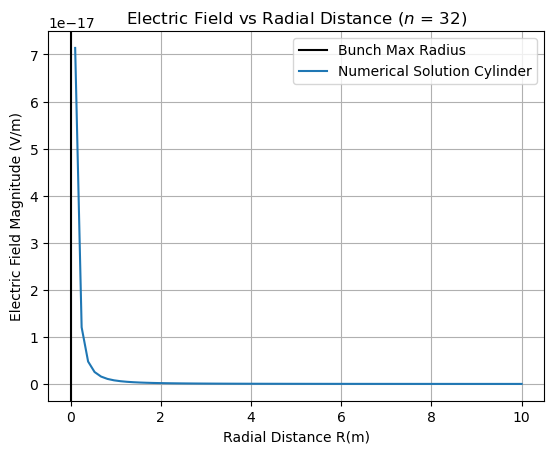

In [36]:
# Plotting
plt.grid()
plt.axvline(x=rad_cyl, label="Bunch Max Radius", color="k", linestyle='-')
plt.plot(mesh, np.array(lb_efld_mags_binned1D), '-',label = "Numerical Solution Cylinder")
plt.xlabel("Radial Distance R(m)")
plt.ylabel("Electric Field Magnitude (V/m)")
plt.legend()
plt.title(f"Electric Field vs Radial Distance ($n$ = {q_pts})")
plt.show()

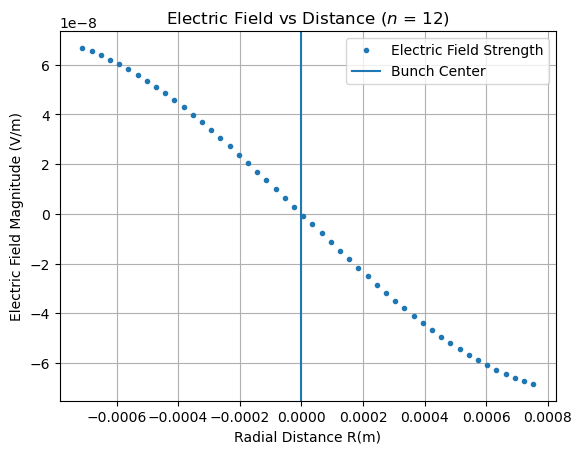

In [44]:
###
# STEP 4: Solve coulomb electric field  equation along the x direction,
#         to get the electric field (will be used to update each particle's force)
###
def gaussQuad1D(fxn, x_bounds, n):
    """1-D Gaussian Quadrature using Legendre Polynomials"""
    roots, weights = leggauss(n)

    a, b = x_bounds

    sum = 0
    # perform the summation
    for i in range(n):
        # get the roots into a,b from -1,1
        u = linTransform(roots[i], a, b)
        sum += weights[i] * fxn(u)

    # multiply by the coefficents from the variable substitution
    return 0.5 * (b - a) * sum

def coulombEfld1D(x_field: float, bunch_length: float, quad_points: int, R: float, rho=None):
    """Compute 1D electric field with cylindrical regularization of radius R"""
    if rho is None:
        rho = lambda x: 1  # Uniform density

    def integrand(x_source):
        separation = x_field - x_source
        return rho(x_source) * separation / (separation**2 + R**2)**(3/2)

    return gaussQuad1D(
        fxn=integrand,
        x_bounds=(-bunch_length/2, bunch_length/2),
        n=quad_points
    ) / (4 * np.pi * EPSILON_0)

### PARAMETERS ###
bunch_length = lb_mgf.bins[-1] - lb_mgf.bins[0]

# the mesh on which to evaluate the electric field
x_mesh = np.linspace(lb_mgf.bins[0], lb_mgf.bins[-1], 50)

# number of quadrature points
q_pts = 12

# get the charge density evaluated at x
rho_binned_1D = lambda x: lb_mgf(x)

# let me try doing just a cylinder
efld_internals = [coulombEfld1D(x_field=x, bunch_length=bunch_length, quad_points=q_pts, R=rad_cyl, rho=rho_binned_1D) for x in x_mesh]

# Plotting
plt.grid(True)
plt.plot(x_mesh, efld_internals, '.', label = "Electric Field Strength")
plt.axvline(x = lb_ref_pos[0], label = 'Bunch Center', )
plt.xlabel("Radial Distance R(m)")
plt.ylabel("Electric Field Magnitude (V/m)")
plt.legend()
plt.title(f"Electric Field vs Distance ($n$ = {q_pts})")
plt.show()

How curious. I would have expected this to be shaped like an inverse parabola- near zero in the middle (where the eflds should cancel) and higher at the ends. This surely isn't correct.

In [ ]:
###
# Step 5: Update each particle's forces based on the electric field at its point
###
for particle in particle_array:
    # interpolate the electric field from the mesh
    efld_interp = np.interp(particle.get_3p()[0][0], x_mesh, efld_internals)
    # use F = qE
    particle.force = np.array([particle.charge * efld_interp, 0 ,0])